<a href="https://colab.research.google.com/github/amirmtaghizadegan/robocup/blob/main/robocup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
import cv2
from matplotlib import cm
import numpy as np
from scipy import fft
from google.colab.patches import cv2_imshow

In [48]:
yellow = [(200, 255), (220, 255), (60, 100)]
orange = [(170, 255), (80, 120), (30, 68)]
pink = [(180, 240), (20, 95), (30, 110)]
green = [(132, 185), (195, 255), (68, 130)]
blue = [(0, 10), (0, 10), (239, 255)]
colors = [yellow, orange, pink, green, blue]

In [49]:
img = cv2.imread("/content/drive/MyDrive/robocup/pic.tiff")

In [50]:
def color_segmentation(img, colors):
  pos = np.zeros((*img.shape[:2], len(colors)), dtype = "bool")
  i = 0
  for color in colors:
    y = np.zeros(img.shape, dtype = "bool")
    y[np.logical_and(img[:, :, 0] >= color[2][0], img[:, :, 0] <= color[2][1]), 0] = True
    y[np.logical_and(img[:, :, 1] >= color[1][0], img[:, :, 1] <= color[1][1]), 1] = True
    y[np.logical_and(img[:, :, 2] >= color[0][0], img[:, :, 2] <= color[0][1]), 2] = True
    pos[:, :, i] = y[:, :, 0] & y[:, :, 1] & y[:, :, 2]
    i += 1
  return pos

In [51]:
pos = color_segmentation(img, colors)

In [52]:
img2 = img * np.sum(pos, axis = 2)[:, :, np.newaxis]

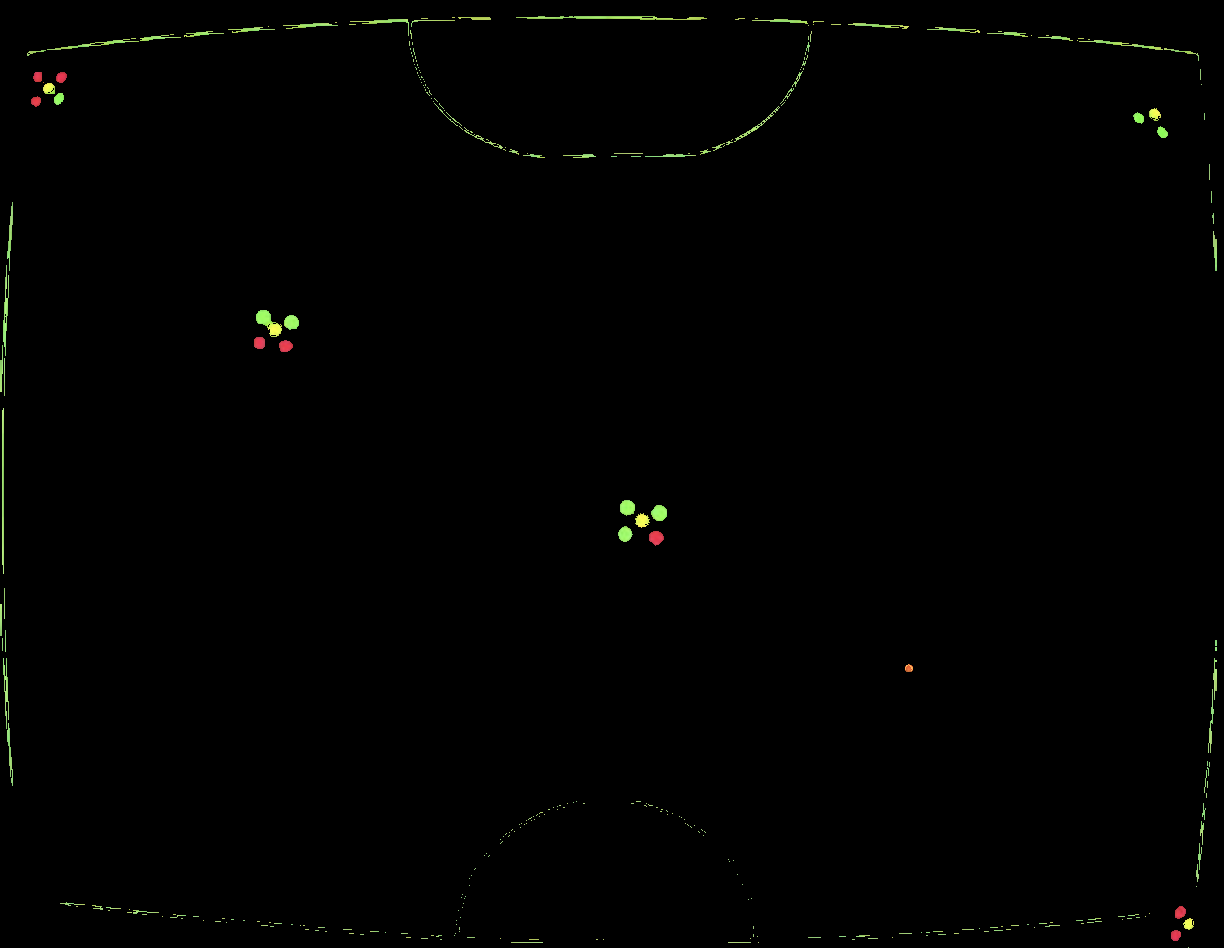

In [53]:
# cv2_imshow(img);
cv2_imshow(img2);

In [65]:
from sklearn.cluster import DBSCAN
def sslDetect(pos, colors):
  color_clusters = {}
  for j in range(pos.shape[2]):
    locs = np.array(np.where(pos[:, :, j])).T
    db = DBSCAN(eps=3, min_samples=25).fit(locs[:, :2])
    labels = db.labels_
    locs = np.c_[locs, labels[:, np.newaxis]]
    locs = locs[locs[:, -1] >= 0, :]
    clusters = np.zeros((np.unique(locs[:, -1]).shape[0], locs.shape[1]), dtype = "uint64")
    for i in range(clusters.shape[0]):
      clusters[i, :] = np.mean(locs[locs[:, -1] == i, :], axis = 0)
    color_clusters.update({colors[j]: clusters})
  return color_clusters

In [66]:
color_clusters = sslDetect(pos[:, :, :4], colors = ["yellow", "orange", "pink", "green"])
# columns are: x y cluster_number
color_clusters

{'yellow': array([[  87,   47,    0],
        [ 113, 1154,    1],
        [ 328,  274,    2],
        [ 520,  641,    3],
        [ 923, 1188,    4]], dtype=uint64),
 'orange': array([[668, 908,   0]], dtype=uint64),
 'pink': array([[  76,   37,    0],
        [  76,   60,    1],
        [ 100,   35,    2],
        [ 342,  259,    3],
        [ 345,  285,    4],
        [ 537,  655,    5],
        [ 912, 1179,    6],
        [ 934, 1175,    7]], dtype=uint64),
 'green': array([[  98,   58,    0],
        [ 117, 1138,    1],
        [ 132, 1161,    2],
        [ 317,  263,    3],
        [ 321,  291,    4],
        [ 507,  626,    5],
        [ 512,  658,    6],
        [ 533,  624,    7]], dtype=uint64)}

In [67]:
def insertText(img, message, loc, color = (0, 0, 255)):
  # Write some Text

  font                   = cv2.FONT_HERSHEY_SIMPLEX
  bottomLeftCornerOfText = loc
  fontScale              = 0.5
  fontColor              = color
  thickness              = 2
  lineType               = 2

  cv2.putText(img, message, 
      bottomLeftCornerOfText, 
      font, 
      fontScale,
      fontColor,
      thickness,
      lineType)
  
  return img

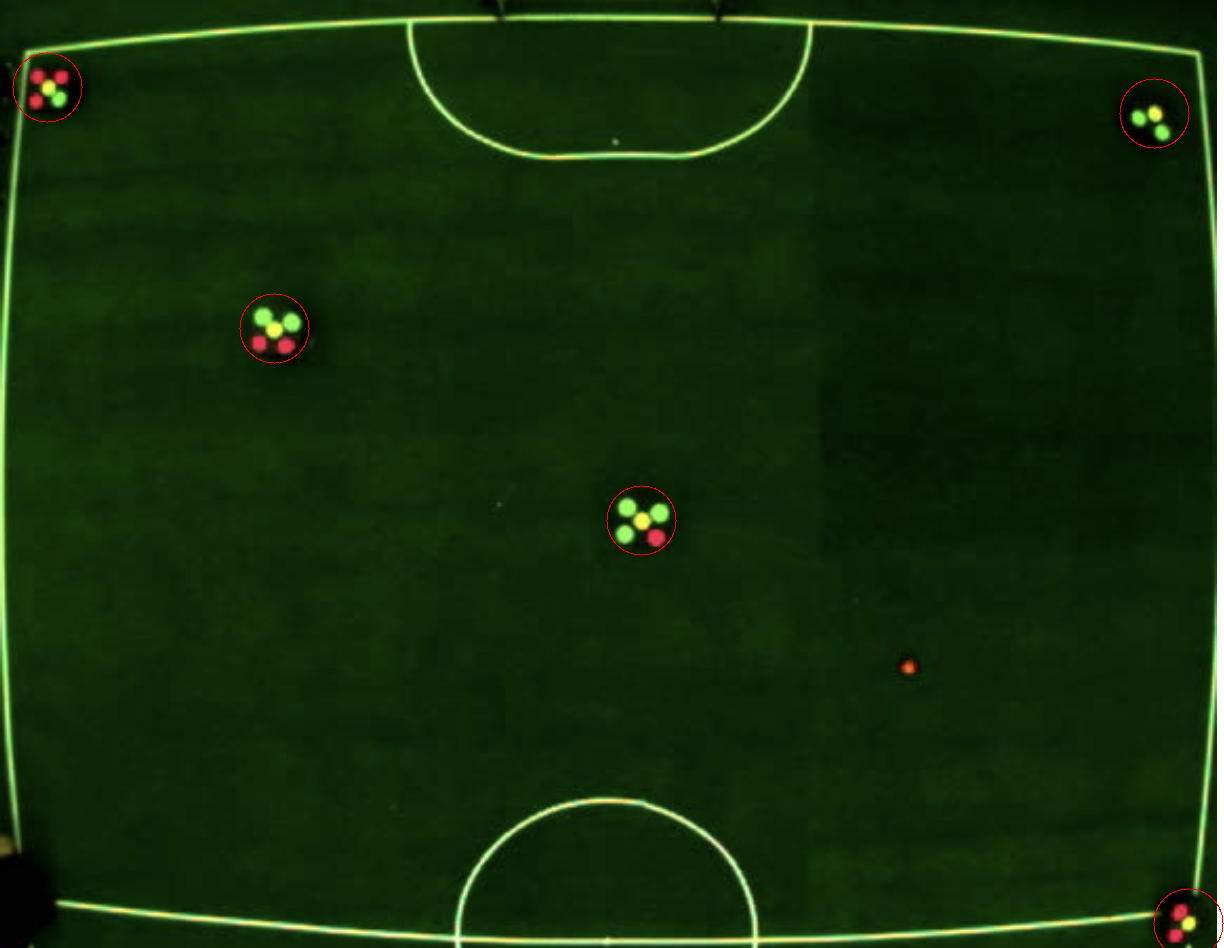

In [72]:
centroid = color_clusters["yellow"]
img = cv2.imread("/content/drive/MyDrive/robocup/pic.tiff")
x = np.arange(0, img.shape[1], 1)
y = np.arange(0, img.shape[0], 1)
x, y = np.meshgrid(x, y)
for i in range(centroid.shape[0]):
  z1 = (x-centroid[i, 1])**2 + (y-centroid[i, 0])**2
  z2 = (z1 <= 35**2)
  z3 = z1 > 34**2
  z4 = 255 * np.logical_and(z2, z3)
  z5 = np.where(z4 == 255)
  img[z5[0], z5[1], 0] = 0
  img[z5[0], z5[1], 1] = 0
  img[z5[0], z5[1], 2] = 255
cv2_imshow(img)

In [73]:
def counter(color_clusters, main_color = "yellow", colors = ["pink", "green"], r = 35):
  centers = color_clusters["yellow"][:, :2]
  count = np.zeros((centers.shape[0], len(colors)), dtype = "uint8")
  for i in range(centers.shape[0]):
    for j in range(len(colors)):
      x = color_clusters[colors[j]][:, 0]
      y = color_clusters[colors[j]][:, 1]
      count[i, j] = sum((x - centers[i, 0]) ** 2 + (y - centers[i, 1]) ** 2 < r ** 2)
  return count
    

In [74]:
def classifier(count):
  if count[0] == 2 and count[1] == 0:
    return 0
  elif count[0] == 3 and count[1] == 1:
    return 1
  elif count[0] == 2 and count[1] == 2:
    return 2
  elif count[0] == 0 and count[1] == 2:
    return 3
  elif count[0] == 1 and count[1] == 3:
    return 4
  else:
    return "error"

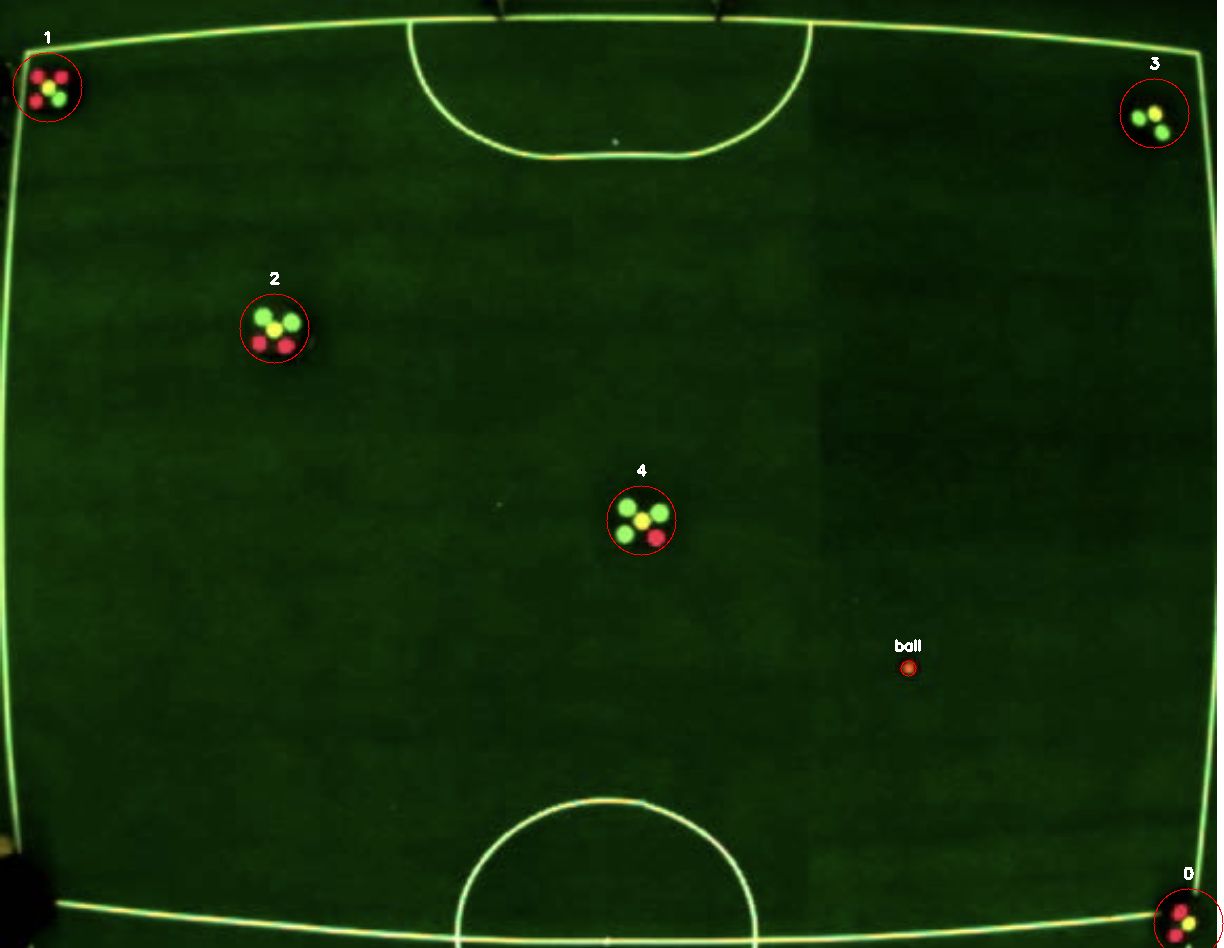

In [81]:
counts = counter(color_clusters)
centroid = color_clusters["yellow"]
img = cv2.imread("/content/drive/MyDrive/robocup/pic.tiff")
x = np.arange(0, img.shape[1], 1)
y = np.arange(0, img.shape[0], 1)
x, y = np.meshgrid(x, y)
## detecting 
for i in range(centroid.shape[0]):
  z1 = (x - centroid[i, 1])**2 + (y - centroid[i, 0])**2
  z2 = (z1 <= 35**2)
  z3 = z1 > 34**2
  z4 = 255 * np.logical_and(z2, z3)
  z5 = np.where(z4 == 255)
  img[z5[0], z5[1], 0] = 0
  img[z5[0], z5[1], 1] = 0
  img[z5[0], z5[1], 2] = 255
  id = np.argmin(z5[0])
  text_loc = (z5[1][id]-5, z5[0][id]-10)
  img = insertText(img, str(classifier(counts[i, :])), text_loc, color = (255, 255, 255))
# detecting ball
ball = color_clusters["orange"]
z1 = (x-ball[0, 1])**2 + (y-ball[0, 0])**2
z2 = (z1 <= 8**2)
z3 = z1 > 7**2
z4 = 255 * np.logical_and(z2, z3)
z5 = np.where(z4 == 255)
img[z5[0], z5[1], 0] = 0
img[z5[0], z5[1], 1] = 0
img[z5[0], z5[1], 2] = 255
id = np.argmin(z5[0])
text_loc = (z5[1][id]-14, z5[0][id]-10)
img = insertText(img, "ball", text_loc, color = (255, 255, 255))
cv2_imshow(img)